# ![Banner](https://github.com/LittleHouse75/flatiron-resources/raw/main/NevitsBanner.png)
---
# Experiment 2 — BART & T5 (Pretrained Seq2Seq Models)
### Purpose-Built Encoder-Decoder Summarization
---

This notebook implements **Experiment 2** for the capstone project:

**Goal:**  
Evaluate purpose-built sequence-to-sequence models for dialogue summarization:

- **BART** (`facebook/bart-base`) — Denoising autoencoder pretrained for seq2seq tasks
- **T5** (`t5-small`) — Text-to-text transformer pretrained on C4

Unlike Experiment 1's "Frankenstein" BERT→GPT-2, these models have **pretrained cross-attention**
layers, meaning the encoder and decoder already know how to communicate.

**What This Notebook Covers:**
1. Model construction and tokenizer setup
2. Fine-tuning on SAMSum using `Seq2SeqTrainer`
3. Evaluation on both validation and **test sets**
4. ROUGE metrics and qualitative analysis
5. Side-by-side comparison of BART vs T5

**Note:** This notebook parallels the structure of `02_experiment1_bert_gpt2-revised.ipynb`
for consistency across experiments.

## 1. Environment Setup

In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import random
import numpy as np
import pandas as pd
import torch
from pathlib import Path
import sys
import warnings
import matplotlib.pyplot as plt

# Mute common warnings
warnings.filterwarnings("ignore", message=".*requires_grad.*")
warnings.filterwarnings("ignore", category=FutureWarning)

# Project root for imports
PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU: AMD Radeon RX 9070 XT
Memory: 17.1 GB


## 2. Configuration

All hyperparameters and paths in one place for easy modification.

**Note:** Parameters are aligned with Experiment 1 for fair comparison.

In [2]:
# =============================================================================
# TRAINING FLAGS
# =============================================================================
RUN_TRAINING_BART = True  # Set False to load from checkpoint
RUN_TRAINING_T5 = True    # Set False to load from checkpoint

# =============================================================================
# MODEL CONFIGURATION
# =============================================================================
BART_MODEL_NAME = "facebook/bart-base"
T5_MODEL_NAME = "t5-small"
T5_PREFIX = "summarize: "  # Required prefix for T5

# =============================================================================
# SEQUENCE LENGTHS
# =============================================================================
MAX_SOURCE_LEN = 512  # Dialogue input length
MAX_TARGET_LEN = 64   # Summary output length (aligned with Experiment 1)

# =============================================================================
# TRAINING HYPERPARAMETERS
# (Aligned with Experiment 1 for fair comparison)
# =============================================================================
BATCH_SIZE = 4
GRAD_ACCUM_STEPS = 2        # Effective batch size = 4 * 2 = 8
NUM_EPOCHS = 20             # Aligned with Experiment 1
LEARNING_RATE = 5e-5
WARMUP_STEPS = 500
WEIGHT_DECAY = 0.01
LOGGING_STEPS = 50          # Aligned with Experiment 1

# Generation settings
NUM_BEAMS = 4

# =============================================================================
# PATHS
# =============================================================================
# BART paths
BART_OUTPUT_DIR = PROJECT_ROOT / "models" / "bart"
BART_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
BART_CHECKPOINT_DIR = BART_OUTPUT_DIR / "checkpoints"
BART_BEST_DIR = BART_OUTPUT_DIR / "best"
BART_HISTORY_PATH = BART_OUTPUT_DIR / "training_history.csv"
BART_TEST_RESULTS_PATH = BART_OUTPUT_DIR / "test_results.csv"

# T5 paths
T5_OUTPUT_DIR = PROJECT_ROOT / "models" / "t5"
T5_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
T5_CHECKPOINT_DIR = T5_OUTPUT_DIR / "checkpoints"
T5_BEST_DIR = T5_OUTPUT_DIR / "best"
T5_HISTORY_PATH = T5_OUTPUT_DIR / "training_history.csv"
T5_TEST_RESULTS_PATH = T5_OUTPUT_DIR / "test_results.csv"

print("Configuration loaded.")
print(f"  BART model: {BART_MODEL_NAME}")
print(f"  T5 model: {T5_MODEL_NAME}")
print(f"  Effective batch size: {BATCH_SIZE * GRAD_ACCUM_STEPS}")
print(f"  BART output: {BART_OUTPUT_DIR}")
print(f"  T5 output: {T5_OUTPUT_DIR}")

Configuration loaded.
  BART model: facebook/bart-base
  T5 model: t5-small
  Effective batch size: 8
  BART output: /home/timnevits/projects/flatiron-language-models-for-ai/models/bart
  T5 output: /home/timnevits/projects/flatiron-language-models-for-ai/models/t5


## 3. Load SAMSum Data

In [3]:
from src.data.load_data import load_samsum

train_df, val_df, test_df = load_samsum()

print(f"Dataset sizes:")
print(f"  Train:      {len(train_df):,} examples")
print(f"  Validation: {len(val_df):,} examples")
print(f"  Test:       {len(test_df):,} examples")

/home/timnevits/miniconda3/envs/rocm312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset sizes:
  Train:      14,731 examples
  Validation: 818 examples
  Test:       819 examples


In [4]:
# Quick peek at the data
print("Sample dialogue:")
print("-" * 40)
print(train_df.iloc[0]["dialogue"][:300], "...")
print()
print("Sample summary:")
print("-" * 40)
print(train_df.iloc[0]["summary"])

Sample dialogue:
----------------------------------------
Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-) ...

Sample summary:
----------------------------------------
Amanda baked cookies and will bring Jerry some tomorrow.


## 4. Shared Imports and Utilities

Import common components used by both BART and T5.

In [5]:
from datasets import Dataset
from transformers import (
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    EarlyStoppingCallback,
)
import evaluate

# Load ROUGE metric (shared by both models)
rouge_metric = evaluate.load("rouge")

def compute_metrics(eval_pred, tokenizer):
    """
    Compute ROUGE scores for evaluation.
    This function is parameterized by tokenizer to work with both BART and T5.
    """
    predictions, labels = eval_pred
    
    # Replace -100 with pad token id for decoding
    predictions = np.where(predictions != -100, predictions, tokenizer.pad_token_id)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    
    # Decode predictions and labels
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Clean up whitespace
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]
    
    # Compute ROUGE
    result = rouge_metric.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True,
    )
    
    # Convert to percentages for readability
    result = {k: round(v * 100, 2) for k, v in result.items()}
    
    return result

print("Shared utilities loaded.")

Shared utilities loaded.


---
# PART A: BART
---

BART (Bidirectional and Auto-Regressive Transformers) is a denoising autoencoder
pretrained by corrupting text and learning to reconstruct it. This makes it
naturally suited for seq2seq tasks like summarization.

## 5A. BART Tokenizer Setup

In [6]:
from transformers import BartTokenizer

bart_tokenizer = BartTokenizer.from_pretrained(BART_MODEL_NAME)

print(f"BART Tokenizer: {bart_tokenizer.__class__.__name__}")
print(f"  Vocab size: {len(bart_tokenizer):,}")
print(f"  Pad token: '{bart_tokenizer.pad_token}' (id: {bart_tokenizer.pad_token_id})")
print(f"  BOS token: '{bart_tokenizer.bos_token}' (id: {bart_tokenizer.bos_token_id})")
print(f"  EOS token: '{bart_tokenizer.eos_token}' (id: {bart_tokenizer.eos_token_id})")

BART Tokenizer: BartTokenizer
  Vocab size: 50,265
  Pad token: '<pad>' (id: 1)
  BOS token: '<s>' (id: 0)
  EOS token: '</s>' (id: 2)


## 6A. Build or Load BART Model

In [7]:
from transformers import BartForConditionalGeneration

if RUN_TRAINING_BART:
    print("Building fresh BART model for training...")
    
    bart_model = BartForConditionalGeneration.from_pretrained(BART_MODEL_NAME)
    
    # Configure generation defaults
    bart_model.config.max_length = MAX_TARGET_LEN
    bart_model.config.num_beams = NUM_BEAMS
    bart_model.config.early_stopping = True
    
    print(f"\nBART model built successfully!")
    
else:
    print(f"Loading BART model from checkpoint: {BART_BEST_DIR}")
    bart_model = BartForConditionalGeneration.from_pretrained(BART_BEST_DIR)
    bart_tokenizer = BartTokenizer.from_pretrained(BART_BEST_DIR)
    print("BART model loaded successfully!")

# Move to device
bart_model = bart_model.to(device)

# Count parameters
total_params = sum(p.numel() for p in bart_model.parameters())
trainable_params = sum(p.numel() for p in bart_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Building fresh BART model for training...

BART model built successfully!


/home/timnevits/miniconda3/envs/rocm312/lib/python3.12/site-packages/torch/nn/modules/module.py:1329: UserWarning: expandable_segments not supported on this platform (Triggered internally at /pytorch/c10/hip/HIPAllocatorConfig.h:29.)
  return t.to(



Total parameters: 139,420,416
Trainable parameters: 139,420,416


## 7A. Prepare BART Datasets

In [8]:
def preprocess_bart(examples):
    """
    Tokenize dialogues and summaries for BART.
    BART doesn't need a task prefix.
    """
    # Encode dialogues
    model_inputs = bart_tokenizer(
        examples["dialogue"],
        max_length=MAX_SOURCE_LEN,
        truncation=True,
        padding="max_length",
    )
    
    # Encode summaries (as labels)
    labels = bart_tokenizer(
        text_target=examples["summary"],
        max_length=MAX_TARGET_LEN,
        truncation=True,
        padding="max_length",
    )
    
    # Replace padding token id with -100 for loss calculation
    labels_ids = np.array(labels["input_ids"])
    labels_ids[labels_ids == bart_tokenizer.pad_token_id] = -100
    
    model_inputs["labels"] = labels_ids.tolist()
    return model_inputs


# Convert DataFrames to HuggingFace Datasets
print("Converting to HuggingFace Datasets...")
bart_train_dataset = Dataset.from_pandas(train_df[["dialogue", "summary"]])
bart_val_dataset = Dataset.from_pandas(val_df[["dialogue", "summary"]])
bart_test_dataset = Dataset.from_pandas(test_df[["dialogue", "summary"]])

# Tokenize
print("Tokenizing datasets for BART...")
bart_tokenized_train = bart_train_dataset.map(
    preprocess_bart,
    batched=True,
    remove_columns=["dialogue", "summary"],
    desc="Tokenizing train",
)

bart_tokenized_val = bart_val_dataset.map(
    preprocess_bart,
    batched=True,
    remove_columns=["dialogue", "summary"],
    desc="Tokenizing validation",
)

bart_tokenized_test = bart_test_dataset.map(
    preprocess_bart,
    batched=True,
    remove_columns=["dialogue", "summary"],
    desc="Tokenizing test",
)

print(f"\nBART tokenized datasets:")
print(f"  Train: {len(bart_tokenized_train):,} examples")
print(f"  Validation: {len(bart_tokenized_val):,} examples")
print(f"  Test: {len(bart_tokenized_test):,} examples")

Converting to HuggingFace Datasets...
Tokenizing datasets for BART...


Tokenizing test: 100%|██████████| 819/819 [00:00<00:00, 1254.87 examples/s]


BART tokenized datasets:
  Train: 14,731 examples
  Validation: 818 examples
  Test: 819 examples


## 8A. BART Data Collator and Metrics

In [9]:
bart_data_collator = DataCollatorForSeq2Seq(
    tokenizer=bart_tokenizer,
    model=bart_model,
    label_pad_token_id=-100,
)

# Create metrics function with BART tokenizer
def bart_compute_metrics(eval_pred):
    return compute_metrics(eval_pred, bart_tokenizer)

print("BART data collator and metrics configured.")

BART data collator and metrics configured.


## 9A. Training BART with Seq2SeqTrainer

In [10]:
print("Setting up BART Seq2SeqTrainer...")
print(f"\nTraining configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Gradient accumulation: {GRAD_ACCUM_STEPS}")
print(f"  Effective batch size: {BATCH_SIZE * GRAD_ACCUM_STEPS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Warmup steps: {WARMUP_STEPS}")
print(f"  Weight decay: {WEIGHT_DECAY}")

bart_training_args = Seq2SeqTrainingArguments(
    output_dir=str(BART_CHECKPOINT_DIR),
    
    # Training
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRAD_ACCUM_STEPS,
    
    # Optimization
    learning_rate=LEARNING_RATE,
    warmup_steps=WARMUP_STEPS,
    weight_decay=WEIGHT_DECAY,
    
    # Evaluation & Saving
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="rougeL",
    greater_is_better=True,
    save_total_limit=2,
    
    # Generation during evaluation
    predict_with_generate=True,
    generation_max_length=MAX_TARGET_LEN,
    generation_num_beams=NUM_BEAMS,
    
    # Logging
    logging_dir=str(BART_OUTPUT_DIR / "logs"),
    logging_strategy="steps",
    logging_steps=LOGGING_STEPS,
    
    # Performance
    fp16=torch.cuda.is_available(),
)

bart_trainer = Seq2SeqTrainer(
    model=bart_model,
    args=bart_training_args,
    train_dataset=bart_tokenized_train,
    eval_dataset=bart_tokenized_val,
    tokenizer=bart_tokenizer,
    data_collator=bart_data_collator,
    compute_metrics=bart_compute_metrics,
    callbacks=[EarlyStoppingCallback(
        early_stopping_patience=2,
        early_stopping_threshold=0.002,
    )],
)

print("\nBART Trainer configured successfully!")

Setting up BART Seq2SeqTrainer...

Training configuration:
  Epochs: 20
  Batch size: 4
  Gradient accumulation: 2
  Effective batch size: 8
  Learning rate: 5e-05
  Warmup steps: 500
  Weight decay: 0.01

BART Trainer configured successfully!


In [11]:
if RUN_TRAINING_BART:
    print("="*60)
    print("STARTING BART TRAINING")
    print("="*60)
    
    bart_train_result = bart_trainer.train()
    
    print("\n" + "="*60)
    print("BART TRAINING COMPLETE")
    print("="*60)
    print(f"\nTraining time: {bart_train_result.metrics['train_runtime']:.1f} seconds")
    print(f"Final training loss: {bart_train_result.metrics['train_loss']:.4f}")
else:
    print("Skipping BART training (RUN_TRAINING_BART=False)")
    print("Will use loaded model for evaluation.")

STARTING BART TRAINING


/home/timnevits/miniconda3/envs/rocm312/lib/python3.12/site-packages/transformers/integrations/sdpa_attention.py:96: UserWarning: Using AOTriton backend for Efficient Attention forward... (Triggered internally at /pytorch/aten/src/ATen/native/transformers/hip/attention.hip:1180.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
/home/timnevits/miniconda3/envs/rocm312/lib/python3.12/site-packages/transformers/integrations/sdpa_attention.py:96: UserWarning: Using AOTriton backend for Flash Attention forward... (Triggered internally at /pytorch/aten/src/ATen/native/transformers/hip/flash_attn/flash_api.h:267.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
/home/timnevits/miniconda3/envs/rocm312/lib/python3.12/site-packages/torch/autograd/graph.py:823: UserWarning: Using AOTriton backend for Efficient Attention backward... (Triggered internally at /pytorch/aten/src/ATen/native/transformers/hip/attention_backward.hip:463.)
  return Variable._execution_en

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,1.838900,1.607053,49.730000,25.660000,41.580000,41.570000
2,1.621100,1.562284,50.640000,26.800000,42.570000,42.580000
3,1.315500,1.561045,50.470000,26.390000,42.280000,42.270000
4,1.165100,1.578680,51.590000,27.770000,43.510000,43.460000
5,1.037900,1.629537,51.530000,27.040000,42.710000,42.720000
6,0.911800,1.687582,51.690000,27.330000,43.040000,43.070000


/home/timnevits/miniconda3/envs/rocm312/lib/python3.12/site-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].



BART TRAINING COMPLETE

Training time: 1974.3 seconds
Final training loss: 1.3156


In [12]:
if RUN_TRAINING_BART:
    print(f"\nSaving best BART model to: {BART_BEST_DIR}")
    bart_trainer.save_model(str(BART_BEST_DIR))
    bart_tokenizer.save_pretrained(BART_BEST_DIR)
    bart_trainer.save_state()
    print("BART model and tokenizer saved!")


Saving best BART model to: /home/timnevits/projects/flatiron-language-models-for-ai/models/bart/best
BART model and tokenizer saved!


## 10A. BART Training History & Loss Curves

In [13]:
if RUN_TRAINING_BART:
    # Extract training history from trainer state
    bart_log_history = bart_trainer.state.log_history
    
    # Separate training and evaluation logs
    bart_train_logs = [log for log in bart_log_history if "loss" in log and "eval_loss" not in log]
    bart_eval_logs = [log for log in bart_log_history if "eval_loss" in log]
    
    # Get the last training loss for each epoch
    bart_epoch_train_losses = {}
    for log in bart_train_logs:
        epoch = round(log.get("epoch", 0))
        bart_epoch_train_losses[epoch] = log["loss"]
    
    # Create history DataFrame - deduplicate by epoch
    bart_history_data = {}
    for eval_log in bart_eval_logs:
        epoch = round(eval_log.get("epoch", 0))
        if epoch not in bart_history_data:
            bart_history_data[epoch] = {
                "epoch": epoch,
                "train_loss": bart_epoch_train_losses.get(epoch, np.nan),
                "val_loss": eval_log.get("eval_loss", np.nan),
                "rouge1": eval_log.get("eval_rouge1", np.nan),
                "rouge2": eval_log.get("eval_rouge2", np.nan),
                "rougeL": eval_log.get("eval_rougeL", np.nan),
                "rougeLsum": eval_log.get("eval_rougeLsum", np.nan),
            }
    
    bart_history_df = pd.DataFrame(list(bart_history_data.values()))
    bart_history_df = bart_history_df.sort_values("epoch").reset_index(drop=True)
    
    bart_history_df.to_csv(BART_HISTORY_PATH, index=False)
    print(f"BART training history saved to: {BART_HISTORY_PATH}")
    
else:
    if BART_HISTORY_PATH.exists():
        bart_history_df = pd.read_csv(BART_HISTORY_PATH)
        print(f"Loaded BART training history from: {BART_HISTORY_PATH}")
    else:
        bart_history_df = None
        print("No BART training history found.")

BART training history saved to: /home/timnevits/projects/flatiron-language-models-for-ai/models/bart/training_history.csv


In [14]:
if bart_history_df is not None:
    print("\n" + "="*60)
    print("BART TRAINING HISTORY")
    print("="*60)
    display(bart_history_df)


BART TRAINING HISTORY


,epoch,train_loss,val_loss,rouge1,rouge2,rougeL,rougeLsum
0,1,1.6160,1.607053,49.73,25.66,41.58,41.57
1,2,1.3241,1.562284,50.64,26.80,42.57,42.58
2,3,1.1641,1.561045,50.47,26.39,42.28,42.27
3,4,1.0225,1.578680,51.59,27.77,43.51,43.46
4,5,0.8491,1.629537,51.53,27.04,42.71,42.72
5,6,0.9118,1.687582,51.69,27.33,43.04,43.07


Saved BART training curves to: /home/timnevits/projects/flatiron-language-models-for-ai/models/bart/training_curves.png


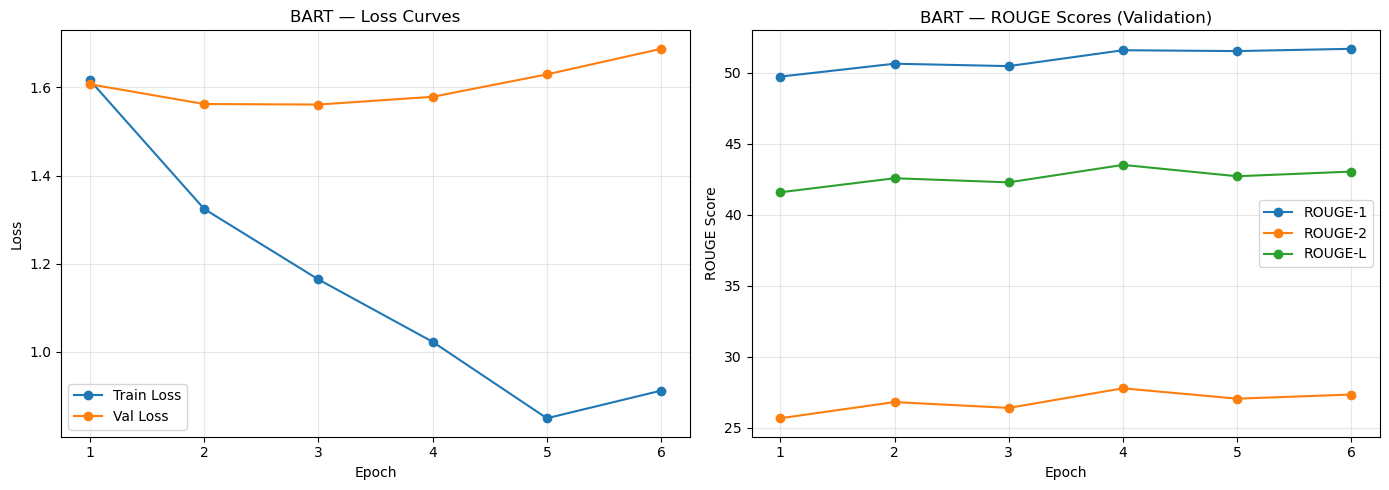

In [15]:
import matplotlib.pyplot as plt

if bart_history_df is not None and len(bart_history_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss curves
    ax = axes[0]
    ax.plot(bart_history_df["epoch"], bart_history_df["train_loss"], marker="o", label="Train Loss")
    ax.plot(bart_history_df["epoch"], bart_history_df["val_loss"], marker="o", label="Val Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("BART — Loss Curves")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # ROUGE curves
    ax = axes[1]
    ax.plot(bart_history_df["epoch"], bart_history_df["rouge1"], marker="o", label="ROUGE-1")
    ax.plot(bart_history_df["epoch"], bart_history_df["rouge2"], marker="o", label="ROUGE-2")
    ax.plot(bart_history_df["epoch"], bart_history_df["rougeL"], marker="o", label="ROUGE-L")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("ROUGE Score")
    ax.set_title("BART — ROUGE Scores (Validation)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    fig_path = BART_OUTPUT_DIR / "training_curves.png"
    plt.savefig(fig_path, dpi=150, bbox_inches="tight")
    print(f"Saved BART training curves to: {fig_path}")
    
    plt.show()

## 11. BART Validation Qualitative Examples

In [16]:
from src.eval.qualitative import qualitative_samples

print("\n" + "="*60)
print("BART VALIDATION SET: Qualitative Examples")
print("="*60)

qualitative_samples(
    df=val_df,
    model=bart_model,
    encoder_tokenizer=bart_tokenizer,
    decoder_tokenizer=bart_tokenizer,
    device=device,
    max_source_len=MAX_SOURCE_LEN,
    max_target_len=MAX_TARGET_LEN,
    source_prefix="",  # No prefix for BART
    n=5,
    seed=SEED,
)


BART VALIDATION SET: Qualitative Examples
--- 5 qualitative samples (seed=42) ---
ID 86
DIALOGUE: Edd: wow, did you hear that they're transferring us to a different department? | Rose: whaaaaat :o | Rose: no! where'd you hear that? | Edd: well, it's quite official | Edd: Anderson just told us | Rose: and do you know what it changes for us? | Edd: they won't change the professors | Edd: but i know the paperwor ...
HUMAN: Rose and Edd will be transferred to a new department. Their professors will not change but paperwork will become more difficult.
MODEL: Anderson transferred Eddie and Rose to a different department.
--------------------------------------------------------------------------------
ID 431
DIALOGUE: Tom: Where is the "Sala del Capitolo" | Kevin: it's in the main building | Martin: The one with the huge round table | Tom: ok! I know. | Tom: Thx ...
HUMAN: "Sala del Capitolo" Tom is looking for is in the main building.
MODEL: The "Sala del Capitolo" is in the main building.


## 12. BART Test Set Evaluation

Evaluate on the **held-out test set** — the final measure of model performance.

In [17]:
print("\n" + "="*60)
print("BART TEST SET EVALUATION")
print("="*60)

print("\nRunning prediction on test set...")
bart_predict_results = bart_trainer.predict(test_dataset=bart_tokenized_test)

# Extract metrics
bart_test_metrics = bart_predict_results.metrics

print("\n" + "-"*40)
print("BART TEST SET RESULTS")
print("-"*40)
print(f"  Loss:      {bart_test_metrics['test_loss']:.4f}")
print(f"  ROUGE-1:   {bart_test_metrics['test_rouge1']:.2f}")
print(f"  ROUGE-2:   {bart_test_metrics['test_rouge2']:.2f}")
print(f"  ROUGE-L:   {bart_test_metrics['test_rougeL']:.2f}")
print(f"  ROUGE-Lsum:{bart_test_metrics['test_rougeLsum']:.2f}")

# Decode predictions
bart_predictions = bart_predict_results.predictions
bart_predictions = np.where(bart_predictions != -100, bart_predictions, bart_tokenizer.pad_token_id)
bart_test_predictions = bart_tokenizer.batch_decode(bart_predictions, skip_special_tokens=True)
bart_test_predictions = [pred.strip() for pred in bart_test_predictions]

print(f"\nGenerated {len(bart_test_predictions)} predictions")


BART TEST SET EVALUATION

Running prediction on test set...



----------------------------------------
BART TEST SET RESULTS
----------------------------------------
  Loss:      1.6255
  ROUGE-1:   50.27
  ROUGE-2:   25.71
  ROUGE-L:   42.13
  ROUGE-Lsum:42.16

Generated 819 predictions


In [18]:
# Save BART test results
bart_test_results_df = pd.DataFrame([{
    "model": "BART",
    "test_loss": bart_test_metrics["test_loss"],
    "rouge1": bart_test_metrics["test_rouge1"],
    "rouge2": bart_test_metrics["test_rouge2"],
    "rougeL": bart_test_metrics["test_rougeL"],
    "rougeLsum": bart_test_metrics["test_rougeLsum"],
}])

bart_test_results_df.to_csv(BART_TEST_RESULTS_PATH, index=False)
print(f"\nBART test results saved to: {BART_TEST_RESULTS_PATH}")
display(bart_test_results_df)

# Save predictions to CSV
bart_full_test_results = test_df.copy()
bart_full_test_results["model_prediction"] = bart_test_predictions
bart_predictions_path = BART_OUTPUT_DIR / "test_predictions.csv"
bart_full_test_results.to_csv(bart_predictions_path, index=False)
print(f"Saved BART predictions to: {bart_predictions_path}")


BART test results saved to: /home/timnevits/projects/flatiron-language-models-for-ai/models/bart/test_results.csv


,model,test_loss,rouge1,rouge2,rougeL,rougeLsum
0,BART,1.62546,50.27,25.71,42.13,42.16


Saved BART predictions to: /home/timnevits/projects/flatiron-language-models-for-ai/models/bart/test_predictions.csv


In [19]:
# BART Test Set Latency Measurement

print("\n" + "="*60)
print("BART TEST SET LATENCY MEASUREMENT")
print("="*60)

import time
from tqdm.auto import tqdm

bart_model.eval()
bart_latencies = []

print(f"\nMeasuring per-example inference latency on {len(test_df)} test examples...")

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="BART latency"):
    dialogue = row["dialogue"]
    
    # Tokenize
    inputs = bart_tokenizer(
        dialogue,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=MAX_SOURCE_LEN,
    ).to(device)
    
    # Time the generation
    t0 = time.perf_counter()
    with torch.no_grad():
        outputs = bart_model.generate(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_length=MAX_TARGET_LEN,
            num_beams=NUM_BEAMS,
            early_stopping=True,
        )
    if device.type == "cuda":
        torch.cuda.synchronize()
    t1 = time.perf_counter()
    
    bart_latencies.append(t1 - t0)

# Add latencies to predictions DataFrame
bart_full_test_results["latency_seconds"] = bart_latencies

# Re-save predictions with latency
bart_full_test_results.to_csv(bart_predictions_path, index=False)
print(f"\nUpdated BART predictions with latency: {bart_predictions_path}")

# Compute and display latency statistics
bart_latency_series = pd.Series(bart_latencies)
bart_latency_stats = bart_latency_series.describe(percentiles=[0.5, 0.9, 0.95])

print(f"\nBART Latency Statistics (seconds):")
print(f"  Count:  {bart_latency_stats['count']:.0f}")
print(f"  Mean:   {bart_latency_stats['mean']:.4f}")
print(f"  Std:    {bart_latency_stats['std']:.4f}")
print(f"  Min:    {bart_latency_stats['min']:.4f}")
print(f"  P50:    {bart_latency_stats['50%']:.4f}")
print(f"  P90:    {bart_latency_stats['90%']:.4f}")
print(f"  P95:    {bart_latency_stats['95%']:.4f}")
print(f"  Max:    {bart_latency_stats['max']:.4f}")

# Save latency summary
bart_latency_summary_df = pd.DataFrame([{
    "model": "BART",
    "count": len(bart_latencies),
    "mean": bart_latency_series.mean(),
    "std": bart_latency_series.std(),
    "min": bart_latency_series.min(),
    "p50": bart_latency_series.quantile(0.50),
    "p90": bart_latency_series.quantile(0.90),
    "p95": bart_latency_series.quantile(0.95),
    "max": bart_latency_series.max(),
}])

bart_latency_summary_path = BART_OUTPUT_DIR / "latency_summary.csv"
bart_latency_summary_df.to_csv(bart_latency_summary_path, index=False)
print(f"\nSaved BART latency summary to: {bart_latency_summary_path}")

display(bart_latency_summary_df)



BART TEST SET LATENCY MEASUREMENT

Measuring per-example inference latency on 819 test examples...


BART latency: 100%|██████████| 819/819 [02:43<00:00,  5.02it/s]



Updated BART predictions with latency: /home/timnevits/projects/flatiron-language-models-for-ai/models/bart/test_predictions.csv

BART Latency Statistics (seconds):
  Count:  819
  Mean:   0.1979
  Std:    0.0780
  Min:    0.0651
  P50:    0.1803
  P90:    0.3043
  P95:    0.3508
  Max:    0.4868

Saved BART latency summary to: /home/timnevits/projects/flatiron-language-models-for-ai/models/bart/latency_summary.csv


,model,count,mean,std,min,p50,p90,p95,max
0,BART,819,0.197943,0.078043,0.065114,0.18035,0.304261,0.350758,0.486804


## 13. BART Test Set Qualitative Examples

In [20]:
print("\n" + "="*60)
print("BART TEST SET: Qualitative Examples")
print("="*60)

qualitative_samples(
    df=test_df,
    model=bart_model,
    encoder_tokenizer=bart_tokenizer,
    decoder_tokenizer=bart_tokenizer,
    device=device,
    max_source_len=MAX_SOURCE_LEN,
    max_target_len=MAX_TARGET_LEN,
    source_prefix="",
    n=5,
    seed=SEED,
)


BART TEST SET: Qualitative Examples
--- 5 qualitative samples (seed=42) ---
ID 86
DIALOGUE: Olafur: are we doing anything for New Year's Eve? | Nathalie: I was thinking about something classy, like opera or sth like that | Zoe: how much does it cost? | Olafur: opera is not for me | Nathalie: so what do you propose? | Nathalie: it's 100$  | Olafur: I was thinking about partying somewhere | Nathalie: part ...
HUMAN: Nathalie, Olafur and Zoe are planning the New Year's Eve. Nathalie wants something classy. Olafur doesn't like opera. They want to go to the Breakfast at Tiffany's party in Soho.
MODEL: Olafur and Nathalie will go to Tiffany's party for New Year's Eve.
--------------------------------------------------------------------------------
ID 432
DIALOGUE: Javier: Hey do you know any tattoo parlors over here with English speaking employees? | Judie: Oh there's Warsaw ink | Javier: the name sounds neat... have you had a tattoo done there? | Judie: nope but my gf has | Javier: got a p

---
# PART B: T5
---

T5 (Text-to-Text Transfer Transformer) frames all NLP tasks as text-to-text problems.
For summarization, we prepend `"summarize: "` to the input text.

## 14. T5 Tokenizer Setup

In [21]:
from transformers import T5Tokenizer

t5_tokenizer = T5Tokenizer.from_pretrained(T5_MODEL_NAME)

print(f"T5 Tokenizer: {t5_tokenizer.__class__.__name__}")
print(f"  Vocab size: {len(t5_tokenizer):,}")
print(f"  Pad token: '{t5_tokenizer.pad_token}' (id: {t5_tokenizer.pad_token_id})")
print(f"  EOS token: '{t5_tokenizer.eos_token}' (id: {t5_tokenizer.eos_token_id})")
print(f"  Task prefix: '{T5_PREFIX}'")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


T5 Tokenizer: T5Tokenizer
  Vocab size: 32,100
  Pad token: '<pad>' (id: 0)
  EOS token: '</s>' (id: 1)
  Task prefix: 'summarize: '


## 15. Build or Load T5 Model

In [22]:
from transformers import T5ForConditionalGeneration

if RUN_TRAINING_T5:
    print("Building fresh T5 model for training...")
    
    t5_model = T5ForConditionalGeneration.from_pretrained(T5_MODEL_NAME)
    
    # Configure generation defaults
    t5_model.config.max_length = MAX_TARGET_LEN
    t5_model.config.num_beams = NUM_BEAMS
    t5_model.config.early_stopping = True
    
    print(f"\nT5 model built successfully!")
    
else:
    print(f"Loading T5 model from checkpoint: {T5_BEST_DIR}")
    t5_model = T5ForConditionalGeneration.from_pretrained(T5_BEST_DIR)
    t5_tokenizer = T5Tokenizer.from_pretrained(T5_BEST_DIR)
    print("T5 model loaded successfully!")

# Move to device
t5_model = t5_model.to(device)

# Count parameters
total_params = sum(p.numel() for p in t5_model.parameters())
trainable_params = sum(p.numel() for p in t5_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Building fresh T5 model for training...

T5 model built successfully!

Total parameters: 60,506,624
Trainable parameters: 60,506,624


## 7B. Prepare T5 Datasets

In [23]:
def preprocess_t5(examples):
    """
    Tokenize dialogues and summaries for T5.
    T5 requires a task prefix (e.g., "summarize: ").
    """
    # Add prefix to dialogues
    inputs = [T5_PREFIX + dialogue for dialogue in examples["dialogue"]]
    
    # Encode dialogues with prefix
    model_inputs = t5_tokenizer(
        inputs,
        max_length=MAX_SOURCE_LEN,
        truncation=True,
        padding="max_length",
    )
    
    # Encode summaries (as labels)
    labels = t5_tokenizer(
        text_target=examples["summary"],
        max_length=MAX_TARGET_LEN,
        truncation=True,
        padding="max_length",
    )
    
    # Replace padding token id with -100 for loss calculation
    labels_ids = np.array(labels["input_ids"])
    labels_ids[labels_ids == t5_tokenizer.pad_token_id] = -100
    
    model_inputs["labels"] = labels_ids.tolist()
    return model_inputs


# Convert DataFrames to HuggingFace Datasets
print("Converting to HuggingFace Datasets...")
t5_train_dataset = Dataset.from_pandas(train_df[["dialogue", "summary"]])
t5_val_dataset = Dataset.from_pandas(val_df[["dialogue", "summary"]])
t5_test_dataset = Dataset.from_pandas(test_df[["dialogue", "summary"]])

# Tokenize
print(f"Tokenizing datasets for T5 (with prefix '{T5_PREFIX}')...")
t5_tokenized_train = t5_train_dataset.map(
    preprocess_t5,
    batched=True,
    remove_columns=["dialogue", "summary"],
    desc="Tokenizing train",
)

t5_tokenized_val = t5_val_dataset.map(
    preprocess_t5,
    batched=True,
    remove_columns=["dialogue", "summary"],
    desc="Tokenizing validation",
)

t5_tokenized_test = t5_test_dataset.map(
    preprocess_t5,
    batched=True,
    remove_columns=["dialogue", "summary"],
    desc="Tokenizing test",
)

print(f"\nT5 tokenized datasets:")
print(f"  Train: {len(t5_tokenized_train):,} examples")
print(f"  Validation: {len(t5_tokenized_val):,} examples")
print(f"  Test: {len(t5_tokenized_test):,} examples")

Converting to HuggingFace Datasets...
Tokenizing datasets for T5 (with prefix 'summarize: ')...


Tokenizing test: 100%|██████████| 819/819 [00:00<00:00, 2703.31 examples/s]


T5 tokenized datasets:
  Train: 14,731 examples
  Validation: 818 examples
  Test: 819 examples


## 8B. T5 Data Collator and Metrics

In [24]:
t5_data_collator = DataCollatorForSeq2Seq(
    tokenizer=t5_tokenizer,
    model=t5_model,
    label_pad_token_id=-100,
)

# Create metrics function with T5 tokenizer
def t5_compute_metrics(eval_pred):
    return compute_metrics(eval_pred, t5_tokenizer)

print("T5 data collator and metrics configured.")

T5 data collator and metrics configured.


## 9B. Training T5 with Seq2SeqTrainer

In [25]:
print("Setting up T5 Seq2SeqTrainer...")
print(f"\nTraining configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Gradient accumulation: {GRAD_ACCUM_STEPS}")
print(f"  Effective batch size: {BATCH_SIZE * GRAD_ACCUM_STEPS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Warmup steps: {WARMUP_STEPS}")
print(f"  Weight decay: {WEIGHT_DECAY}")

t5_training_args = Seq2SeqTrainingArguments(
    output_dir=str(T5_CHECKPOINT_DIR),
    
    # Training
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRAD_ACCUM_STEPS,
    
    # Optimization
    learning_rate=LEARNING_RATE,
    warmup_steps=WARMUP_STEPS,
    weight_decay=WEIGHT_DECAY,
    
    # Evaluation & Saving
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="rougeL",
    greater_is_better=True,
    save_total_limit=2,
    
    # Generation during evaluation
    predict_with_generate=True,
    generation_max_length=MAX_TARGET_LEN,
    generation_num_beams=NUM_BEAMS,
    
    # Logging
    logging_dir=str(T5_OUTPUT_DIR / "logs"),
    logging_strategy="steps",
    logging_steps=LOGGING_STEPS,
    
    # Performance
    fp16=torch.cuda.is_available(),
)

t5_trainer = Seq2SeqTrainer(
    model=t5_model,
    args=t5_training_args,
    train_dataset=t5_tokenized_train,
    eval_dataset=t5_tokenized_val,
    tokenizer=t5_tokenizer,
    data_collator=t5_data_collator,
    compute_metrics=t5_compute_metrics,
    callbacks=[EarlyStoppingCallback(
        early_stopping_patience=2,
        early_stopping_threshold=0.002,
    )],
)

print("\nT5 Trainer configured successfully!")

Setting up T5 Seq2SeqTrainer...

Training configuration:
  Epochs: 20
  Batch size: 4
  Gradient accumulation: 2
  Effective batch size: 8
  Learning rate: 5e-05
  Warmup steps: 500
  Weight decay: 0.01

T5 Trainer configured successfully!


In [26]:
if RUN_TRAINING_T5:
    print("="*60)
    print("STARTING T5 TRAINING")
    print("="*60)
    
    t5_train_result = t5_trainer.train()
    
    print("\n" + "="*60)
    print("T5 TRAINING COMPLETE")
    print("="*60)
    print(f"\nTraining time: {t5_train_result.metrics['train_runtime']:.1f} seconds")
    print(f"Final training loss: {t5_train_result.metrics['train_loss']:.4f}")
else:
    print("Skipping T5 training (RUN_TRAINING_T5=False)")
    print("Will use loaded model for evaluation.")

STARTING T5 TRAINING


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,2.026100,1.777051,45.950000,22.010000,38.060000,38.050000
2,1.929900,1.717957,46.450000,22.770000,38.860000,38.870000
3,1.798300,1.694698,47.450000,23.600000,39.620000,39.560000
4,1.765900,1.679119,47.400000,23.540000,39.560000,39.540000
5,1.736800,1.656628,48.030000,24.160000,40.050000,40.060000
6,1.725500,1.649158,48.780000,24.800000,40.710000,40.700000
7,1.638800,1.649472,48.630000,24.750000,40.470000,40.460000
8,1.659400,1.644130,49.110000,24.870000,40.790000,40.770000
9,1.593000,1.644606,49.130000,25.150000,41.050000,41.030000
10,1.575400,1.636888,49.070000,25.350000,40.860000,40.850000


/home/timnevits/miniconda3/envs/rocm312/lib/python3.12/site-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'early_stopping': True, 'num_beams': 4}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].



T5 TRAINING COMPLETE

Training time: 3147.1 seconds
Final training loss: 1.7370


In [27]:
if RUN_TRAINING_T5:
    print(f"\nSaving best T5 model to: {T5_BEST_DIR}")
    t5_trainer.save_model(str(T5_BEST_DIR))
    t5_tokenizer.save_pretrained(T5_BEST_DIR)
    t5_trainer.save_state()
    print("T5 model and tokenizer saved!")


Saving best T5 model to: /home/timnevits/projects/flatiron-language-models-for-ai/models/t5/best
T5 model and tokenizer saved!


## 10B. T5 Training History & Loss Curves

In [28]:
if RUN_TRAINING_T5:
    # Extract training history from trainer state
    t5_log_history = t5_trainer.state.log_history
    
    # Separate training and evaluation logs
    t5_train_logs = [log for log in t5_log_history if "loss" in log and "eval_loss" not in log]
    t5_eval_logs = [log for log in t5_log_history if "eval_loss" in log]
    
    # Get the last training loss for each epoch
    t5_epoch_train_losses = {}
    for log in t5_train_logs:
        epoch = round(log.get("epoch", 0))
        t5_epoch_train_losses[epoch] = log["loss"]
    
    # Create history DataFrame - deduplicate by epoch
    t5_history_data = {}
    for eval_log in t5_eval_logs:
        epoch = round(eval_log.get("epoch", 0))
        if epoch not in t5_history_data:
            t5_history_data[epoch] = {
                "epoch": epoch,
                "train_loss": t5_epoch_train_losses.get(epoch, np.nan),
                "val_loss": eval_log.get("eval_loss", np.nan),
                "rouge1": eval_log.get("eval_rouge1", np.nan),
                "rouge2": eval_log.get("eval_rouge2", np.nan),
                "rougeL": eval_log.get("eval_rougeL", np.nan),
                "rougeLsum": eval_log.get("eval_rougeLsum", np.nan),
            }
    
    t5_history_df = pd.DataFrame(list(t5_history_data.values()))
    t5_history_df = t5_history_df.sort_values("epoch").reset_index(drop=True)
    
    t5_history_df.to_csv(T5_HISTORY_PATH, index=False)
    print(f"T5 training history saved to: {T5_HISTORY_PATH}")
    
else:
    if T5_HISTORY_PATH.exists():
        t5_history_df = pd.read_csv(T5_HISTORY_PATH)
        print(f"Loaded T5 training history from: {T5_HISTORY_PATH}")
    else:
        t5_history_df = None
        print("No T5 training history found.")

T5 training history saved to: /home/timnevits/projects/flatiron-language-models-for-ai/models/t5/training_history.csv


In [29]:
if t5_history_df is not None:
    print("\n" + "="*60)
    print("T5 TRAINING HISTORY")
    print("="*60)
    display(t5_history_df)


T5 TRAINING HISTORY


,epoch,train_loss,val_loss,rouge1,rouge2,rougeL,rougeLsum
0,1,1.9325,1.777051,45.95,22.01,38.06,38.05
1,2,1.7968,1.717957,46.45,22.77,38.86,38.87
2,3,1.7903,1.694698,47.45,23.60,39.62,39.56
3,4,1.7183,1.679119,47.40,23.54,39.56,39.54
4,5,1.6565,1.656628,48.03,24.16,40.05,40.06
5,6,1.6335,1.649158,48.78,24.80,40.71,40.70
6,7,1.6627,1.649472,48.63,24.75,40.47,40.46
7,8,1.6029,1.644130,49.11,24.87,40.79,40.77
8,9,1.6167,1.644606,49.13,25.15,41.05,41.03
9,10,1.5774,1.636888,49.07,25.35,40.86,40.85


Saved T5 training curves to: /home/timnevits/projects/flatiron-language-models-for-ai/models/t5/training_curves.png


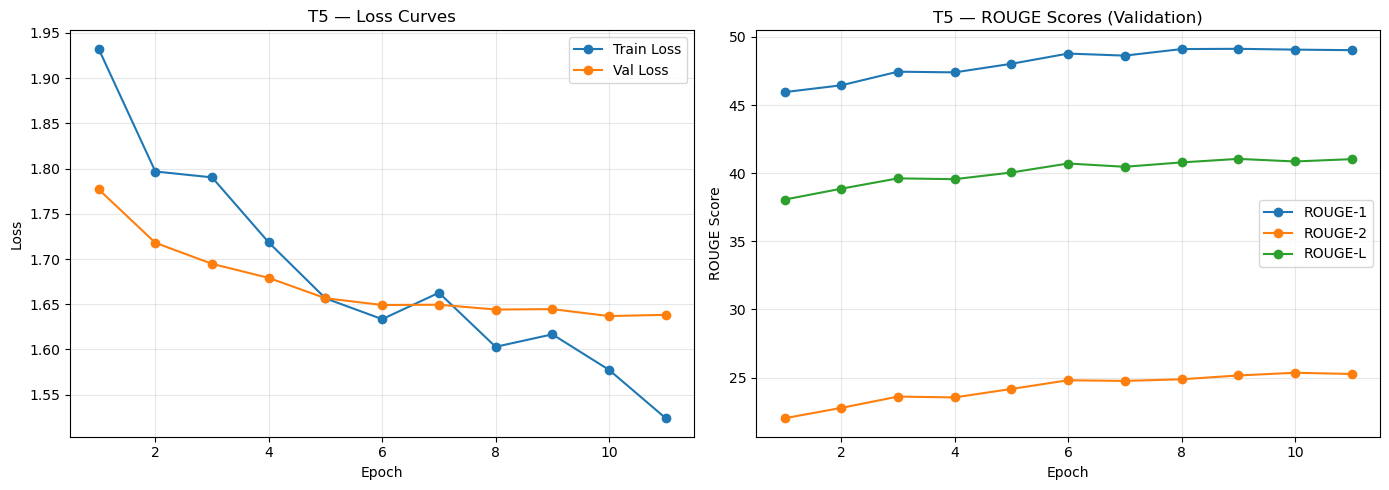

In [30]:
if t5_history_df is not None and len(t5_history_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss curves
    ax = axes[0]
    ax.plot(t5_history_df["epoch"], t5_history_df["train_loss"], marker="o", label="Train Loss")
    ax.plot(t5_history_df["epoch"], t5_history_df["val_loss"], marker="o", label="Val Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("T5 — Loss Curves")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # ROUGE curves
    ax = axes[1]
    ax.plot(t5_history_df["epoch"], t5_history_df["rouge1"], marker="o", label="ROUGE-1")
    ax.plot(t5_history_df["epoch"], t5_history_df["rouge2"], marker="o", label="ROUGE-2")
    ax.plot(t5_history_df["epoch"], t5_history_df["rougeL"], marker="o", label="ROUGE-L")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("ROUGE Score")
    ax.set_title("T5 — ROUGE Scores (Validation)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    fig_path = T5_OUTPUT_DIR / "training_curves.png"
    plt.savefig(fig_path, dpi=150, bbox_inches="tight")
    print(f"Saved T5 training curves to: {fig_path}")
    
    plt.show()

## 11B. T5 Validation Qualitative Examples

In [31]:
from src.eval.qualitative import qualitative_samples

print("\n" + "="*60)
print("T5 VALIDATION SET: Qualitative Examples")
print("="*60)

qualitative_samples(
    df=val_df,
    model=t5_model,
    encoder_tokenizer=t5_tokenizer,
    decoder_tokenizer=t5_tokenizer,
    device=device,
    max_source_len=MAX_SOURCE_LEN,
    max_target_len=MAX_TARGET_LEN,
    source_prefix=T5_PREFIX,  # T5 needs the prefix!
    n=5,
    seed=SEED,
)


T5 VALIDATION SET: Qualitative Examples
--- 5 qualitative samples (seed=42) ---
ID 86
DIALOGUE: Edd: wow, did you hear that they're transferring us to a different department? | Rose: whaaaaat :o | Rose: no! where'd you hear that? | Edd: well, it's quite official | Edd: Anderson just told us | Rose: and do you know what it changes for us? | Edd: they won't change the professors | Edd: but i know the paperwor ...
HUMAN: Rose and Edd will be transferred to a new department. Their professors will not change but paperwork will become more difficult.
MODEL: Anderson is transferring Edd to a different department.
--------------------------------------------------------------------------------
ID 431
DIALOGUE: Tom: Where is the "Sala del Capitolo" | Kevin: it's in the main building | Martin: The one with the huge round table | Tom: ok! I know. | Tom: Thx ...
HUMAN: "Sala del Capitolo" Tom is looking for is in the main building.
MODEL: The "Sala del Capitolo" is in the main building with the h

## 12B. T5 Test Set Evaluation

In [32]:
print("\n" + "="*60)
print("T5 TEST SET EVALUATION")
print("="*60)

print("\nRunning prediction on test set...")
t5_predict_results = t5_trainer.predict(test_dataset=t5_tokenized_test)

# Extract metrics
t5_test_metrics = t5_predict_results.metrics

print("\n" + "-"*40)
print("T5 TEST SET RESULTS")
print("-"*40)
print(f"  Loss:      {t5_test_metrics['test_loss']:.4f}")
print(f"  ROUGE-1:   {t5_test_metrics['test_rouge1']:.2f}")
print(f"  ROUGE-2:   {t5_test_metrics['test_rouge2']:.2f}")
print(f"  ROUGE-L:   {t5_test_metrics['test_rougeL']:.2f}")
print(f"  ROUGE-Lsum:{t5_test_metrics['test_rougeLsum']:.2f}")

# Decode predictions
t5_predictions = t5_predict_results.predictions
t5_predictions = np.where(t5_predictions != -100, t5_predictions, t5_tokenizer.pad_token_id)
t5_test_predictions = t5_tokenizer.batch_decode(t5_predictions, skip_special_tokens=True)
t5_test_predictions = [pred.strip() for pred in t5_test_predictions]

print(f"\nGenerated {len(t5_test_predictions)} predictions")


T5 TEST SET EVALUATION

Running prediction on test set...



----------------------------------------
T5 TEST SET RESULTS
----------------------------------------
  Loss:      1.6645
  ROUGE-1:   47.43
  ROUGE-2:   22.92
  ROUGE-L:   39.08
  ROUGE-Lsum:39.02

Generated 819 predictions


In [33]:
# Save T5 test results
t5_test_results_df = pd.DataFrame([{
    "model": "T5",
    "test_loss": t5_test_metrics["test_loss"],
    "rouge1": t5_test_metrics["test_rouge1"],
    "rouge2": t5_test_metrics["test_rouge2"],
    "rougeL": t5_test_metrics["test_rougeL"],
    "rougeLsum": t5_test_metrics["test_rougeLsum"],
}])

t5_test_results_df.to_csv(T5_TEST_RESULTS_PATH, index=False)
print(f"\nT5 test results saved to: {T5_TEST_RESULTS_PATH}")
display(t5_test_results_df)

# Save predictions to CSV
t5_full_test_results = test_df.copy()
t5_full_test_results["model_prediction"] = t5_test_predictions
t5_predictions_path = T5_OUTPUT_DIR / "test_predictions.csv"
t5_full_test_results.to_csv(t5_predictions_path, index=False)
print(f"Saved T5 predictions to: {t5_predictions_path}")


T5 test results saved to: /home/timnevits/projects/flatiron-language-models-for-ai/models/t5/test_results.csv


,model,test_loss,rouge1,rouge2,rougeL,rougeLsum
0,T5,1.664532,47.43,22.92,39.08,39.02


Saved T5 predictions to: /home/timnevits/projects/flatiron-language-models-for-ai/models/t5/test_predictions.csv


In [34]:
# T5 Test Set Latency Measurement


print("\n" + "="*60)
print("T5 TEST SET LATENCY MEASUREMENT")
print("="*60)

t5_model.eval()
t5_latencies = []

print(f"\nMeasuring per-example inference latency on {len(test_df)} test examples...")

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="T5 latency"):
    dialogue = row["dialogue"]
    
    # Tokenize (T5 needs the prefix!)
    inputs = t5_tokenizer(
        T5_PREFIX + dialogue,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=MAX_SOURCE_LEN,
    ).to(device)
    
    # Time the generation
    t0 = time.perf_counter()
    with torch.no_grad():
        outputs = t5_model.generate(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_length=MAX_TARGET_LEN,
            num_beams=NUM_BEAMS,
            early_stopping=True,
        )
    if device.type == "cuda":
        torch.cuda.synchronize()
    t1 = time.perf_counter()
    
    t5_latencies.append(t1 - t0)

# Add latencies to predictions DataFrame
t5_full_test_results["latency_seconds"] = t5_latencies

# Re-save predictions with latency
t5_full_test_results.to_csv(t5_predictions_path, index=False)
print(f"\nUpdated T5 predictions with latency: {t5_predictions_path}")

# Compute and display latency statistics
t5_latency_series = pd.Series(t5_latencies)
t5_latency_stats = t5_latency_series.describe(percentiles=[0.5, 0.9, 0.95])

print(f"\nT5 Latency Statistics (seconds):")
print(f"  Count:  {t5_latency_stats['count']:.0f}")
print(f"  Mean:   {t5_latency_stats['mean']:.4f}")
print(f"  Std:    {t5_latency_stats['std']:.4f}")
print(f"  Min:    {t5_latency_stats['min']:.4f}")
print(f"  P50:    {t5_latency_stats['50%']:.4f}")
print(f"  P90:    {t5_latency_stats['90%']:.4f}")
print(f"  P95:    {t5_latency_stats['95%']:.4f}")
print(f"  Max:    {t5_latency_stats['max']:.4f}")

# Save latency summary
t5_latency_summary_df = pd.DataFrame([{
    "model": "T5",
    "count": len(t5_latencies),
    "mean": t5_latency_series.mean(),
    "std": t5_latency_series.std(),
    "min": t5_latency_series.min(),
    "p50": t5_latency_series.quantile(0.50),
    "p90": t5_latency_series.quantile(0.90),
    "p95": t5_latency_series.quantile(0.95),
    "max": t5_latency_series.max(),
}])

t5_latency_summary_path = T5_OUTPUT_DIR / "latency_summary.csv"
t5_latency_summary_df.to_csv(t5_latency_summary_path, index=False)
print(f"\nSaved T5 latency summary to: {t5_latency_summary_path}")

display(t5_latency_summary_df)



T5 TEST SET LATENCY MEASUREMENT

Measuring per-example inference latency on 819 test examples...


T5 latency: 100%|██████████| 819/819 [03:06<00:00,  4.38it/s]


Updated T5 predictions with latency: /home/timnevits/projects/flatiron-language-models-for-ai/models/t5/test_predictions.csv

T5 Latency Statistics (seconds):
  Count:  819
  Mean:   0.2269
  Std:    0.0947
  Min:    0.0742
  P50:    0.2063
  P90:    0.3568
  P95:    0.4097
  Max:    0.5184

Saved T5 latency summary to: /home/timnevits/projects/flatiron-language-models-for-ai/models/t5/latency_summary.csv


,model,count,mean,std,min,p50,p90,p95,max
0,T5,819,0.22689,0.094696,0.074214,0.206344,0.356848,0.409725,0.518435


## 13B. T5 Test Set Qualitative Examples

In [35]:
print("\n" + "="*60)
print("T5 TEST SET: Qualitative Examples")
print("="*60)

qualitative_samples(
    df=test_df,
    model=t5_model,
    encoder_tokenizer=t5_tokenizer,
    decoder_tokenizer=t5_tokenizer,
    device=device,
    max_source_len=MAX_SOURCE_LEN,
    max_target_len=MAX_TARGET_LEN,
    source_prefix=T5_PREFIX,
    n=5,
    seed=SEED,
)


T5 TEST SET: Qualitative Examples
--- 5 qualitative samples (seed=42) ---
ID 86
DIALOGUE: Olafur: are we doing anything for New Year's Eve? | Nathalie: I was thinking about something classy, like opera or sth like that | Zoe: how much does it cost? | Olafur: opera is not for me | Nathalie: so what do you propose? | Nathalie: it's 100$  | Olafur: I was thinking about partying somewhere | Nathalie: part ...
HUMAN: Nathalie, Olafur and Zoe are planning the New Year's Eve. Nathalie wants something classy. Olafur doesn't like opera. They want to go to the Breakfast at Tiffany's party in Soho.
MODEL: Nathalie and Olafur are planning a party for New Year's Eve. They are going to Soho.
--------------------------------------------------------------------------------
ID 432
DIALOGUE: Javier: Hey do you know any tattoo parlors over here with English speaking employees? | Judie: Oh there's Warsaw ink | Javier: the name sounds neat... have you had a tattoo done there? | Judie: nope but my gf has |

---
# 14. Side-by-Side Comparison: BART vs T5
---

In [36]:
print("\n" + "="*70)
print("EXPERIMENT 2 — FINAL COMPARISON: BART vs T5")
print("="*70)

# Combine test results
comparison_df = pd.concat([bart_test_results_df, t5_test_results_df], ignore_index=True)
comparison_df = comparison_df.sort_values("rougeL", ascending=False).reset_index(drop=True)

print("\nTest Set Results (sorted by ROUGE-L):")
display(comparison_df)


EXPERIMENT 2 — FINAL COMPARISON: BART vs T5

Test Set Results (sorted by ROUGE-L):


,model,test_loss,rouge1,rouge2,rougeL,rougeLsum
0,BART,1.625460,50.27,25.71,42.13,42.16
1,T5,1.664532,47.43,22.92,39.08,39.02


Saved comparison chart to: /home/timnevits/projects/flatiron-language-models-for-ai/experiments/exp2_comparison.png


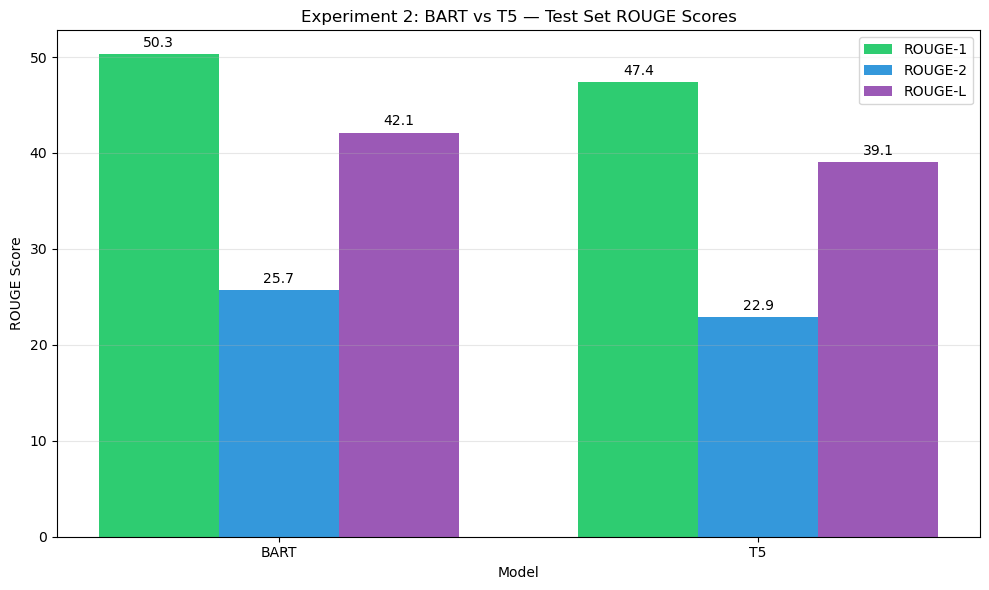

In [37]:
# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

models = comparison_df["model"].tolist()
x = np.arange(len(models))
width = 0.25

r1 = comparison_df["rouge1"].tolist()
r2 = comparison_df["rouge2"].tolist()
rL = comparison_df["rougeL"].tolist()

bars1 = ax.bar(x - width, r1, width, label="ROUGE-1", color="#2ecc71")
bars2 = ax.bar(x, r2, width, label="ROUGE-2", color="#3498db")
bars3 = ax.bar(x + width, rL, width, label="ROUGE-L", color="#9b59b6")

ax.set_xlabel("Model")
ax.set_ylabel("ROUGE Score")
ax.set_title("Experiment 2: BART vs T5 — Test Set ROUGE Scores")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(True, alpha=0.3, axis="y")

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center', va='bottom',
                   fontsize=10)

plt.tight_layout()
fig_path = PROJECT_ROOT / "experiments" / "exp2_comparison.png"
fig_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_path, dpi=150, bbox_inches="tight")
print(f"Saved comparison chart to: {fig_path}")
plt.show()

## Same Examples: BART vs T5

In [38]:
print("\n" + "="*70)
print("QUALITATIVE COMPARISON: Same Test Examples")
print("="*70)

# Sample 3 test examples
sample_indices = test_df.sample(3, random_state=SEED).index.tolist()

for idx in sample_indices:
    row = test_df.loc[idx]
    
    print(f"\n{'='*70}")
    print(f"TEST EXAMPLE (index {idx})")
    print("="*70)
    
    print(f"\n[DIALOGUE]\n{row['dialogue'][:400]}{'...' if len(row['dialogue']) > 400 else ''}")
    print(f"\n[HUMAN SUMMARY]\n{row['summary']}")
    
    # BART prediction
    bart_pred = bart_full_test_results.loc[idx, "model_prediction"]
    
    # T5 prediction
    t5_pred = t5_full_test_results.loc[idx, "model_prediction"]
    
    print(f"\n[BART]\n{bart_pred}")
    print(f"\n[T5]\n{t5_pred}")
    print("-" * 70)


QUALITATIVE COMPARISON: Same Test Examples

TEST EXAMPLE (index 86)

[DIALOGUE]
Olafur: are we doing anything for New Year's Eve?
Nathalie: I was thinking about something classy, like opera or sth like that
Zoe: how much does it cost?
Olafur: opera is not for me
Nathalie: so what do you propose?
Nathalie: it's 100$ 
Olafur: I was thinking about partying somewhere
Nathalie: partying sounds fun, as long as it will be classy
Zoe: <file_link>
Zoe: Breakfast at Tiffany's party sou...

[HUMAN SUMMARY]
Nathalie, Olafur and Zoe are planning the New Year's Eve. Nathalie wants something classy. Olafur doesn't like opera. They want to go to the Breakfast at Tiffany's party in Soho.

[BART]
Olafur and Nathalie will go to Tiffany's party for New Year's Eve.

[T5]
Nathalie and Olafur are planning a party for New Year's Eve. They are going to Soho.
----------------------------------------------------------------------

TEST EXAMPLE (index 432)

[DIALOGUE]
Javier: Hey do you know any tattoo parlors o

## 15. Final Summary

In [39]:
print("\n" + "="*70)
print("EXPERIMENT 2 — FINAL SUMMARY")
print("="*70)

print(f"\nModels Evaluated:")
print(f"  BART: {BART_MODEL_NAME}")
print(f"  T5:   {T5_MODEL_NAME} (prefix: '{T5_PREFIX}')")

print(f"\nTraining Configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Effective batch size: {BATCH_SIZE * GRAD_ACCUM_STEPS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Best model selection: ROUGE-L")

print(f"\nTest Set Performance:")
print(f"\n  BART:")
print(f"    ROUGE-1: {bart_test_metrics['test_rouge1']:.2f}")
print(f"    ROUGE-2: {bart_test_metrics['test_rouge2']:.2f}")
print(f"    ROUGE-L: {bart_test_metrics['test_rougeL']:.2f}")

print(f"\n  T5:")
print(f"    ROUGE-1: {t5_test_metrics['test_rouge1']:.2f}")
print(f"    ROUGE-2: {t5_test_metrics['test_rouge2']:.2f}")
print(f"    ROUGE-L: {t5_test_metrics['test_rougeL']:.2f}")

# Determine winner
if bart_test_metrics['test_rougeL'] > t5_test_metrics['test_rougeL']:
    winner = "BART"
    margin = bart_test_metrics['test_rougeL'] - t5_test_metrics['test_rougeL']
else:
    winner = "T5"
    margin = t5_test_metrics['test_rougeL'] - bart_test_metrics['test_rougeL']

print(f"\n  Winner: {winner} (by {margin:.2f} ROUGE-L points)")

print(f"\nArtifacts:")
print(f"  BART model: {BART_BEST_DIR}")
print(f"  BART predictions: {bart_predictions_path}")
print(f"  T5 model: {T5_BEST_DIR}")
print(f"  T5 predictions: {t5_predictions_path}")

print("\n" + "="*70)


EXPERIMENT 2 — FINAL SUMMARY

Models Evaluated:
  BART: facebook/bart-base
  T5:   t5-small (prefix: 'summarize: ')

Training Configuration:
  Epochs: 20
  Effective batch size: 8
  Learning rate: 5e-05
  Best model selection: ROUGE-L

Test Set Performance:

  BART:
    ROUGE-1: 50.27
    ROUGE-2: 25.71
    ROUGE-L: 42.13

  T5:
    ROUGE-1: 47.43
    ROUGE-2: 22.92
    ROUGE-L: 39.08

  Winner: BART (by 3.05 ROUGE-L points)

Artifacts:
  BART model: /home/timnevits/projects/flatiron-language-models-for-ai/models/bart/best
  BART predictions: /home/timnevits/projects/flatiron-language-models-for-ai/models/bart/test_predictions.csv
  T5 model: /home/timnevits/projects/flatiron-language-models-for-ai/models/t5/best
  T5 predictions: /home/timnevits/projects/flatiron-language-models-for-ai/models/t5/test_predictions.csv



## 16. Key Takeaways

### Architecture

**BART:**
- Denoising autoencoder pretrained by corrupting and reconstructing text
- Naturally suited for generation tasks like summarization
- No task prefix required

**T5:**
- Text-to-text framework that frames all tasks uniformly
- Requires task prefix ("summarize: ") to specify the task
- More flexible for multi-task learning

### Performance

*[Fill in after training completes]*

- Which model achieved better ROUGE scores?
- How many epochs before convergence?
- Training time comparison?

### Comparison to Experiment 1 (BERT→GPT-2)

Both BART and T5 should significantly outperform the custom BERT→GPT-2 architecture because:
1. **Pretrained cross-attention**: The encoder and decoder were trained together
2. **Purpose-built for seq2seq**: These models were designed for generation tasks
3. **Better initialization**: No randomly initialized layers to train from scratch

### Next Steps

- Compare with **Experiment 3** (frontier LLMs via API) as upper bound
- Final comparison in **notebook 05_evaluation_and_comparison.ipynb**